# Data Science - Laboratorio 3
## Modelos Long-Short Term Memory (LSTM)
- - -
### Integrantes:
- Diego Alberto Leiva 21752
- José Pablo Orellana 21970
- - -

### Librerias

In [1]:
# Manipulacion de Datos
import pandas as pd
import numpy as np

# Sistema
import os

# Utilidades
import random

# Visualizacion
import matplotlib.pyplot as plt

# Preprocesamiento
from sklearn.preprocessing import StandardScaler

# PyTorch CUDA
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

### Carga de Datasets

In [2]:
# Leer los archivos de una carpeta y almacenarlos como dataframes
consumos = pd.read_csv('data/consumos_combustibles.csv', sep=';', encoding='utf-8')
importaciones = pd.read_csv('data/importaciones_combustibles.csv', sep=';', encoding='utf-8')
precios = pd.read_csv('data/precios_combustibles.csv', sep=';', encoding='utf-8')

data_frames = {
    'Consumos': consumos,
    'Importaciones': importaciones,
    'Precios': precios
}

# Mostrar los nombres de los archivos
print(f"Se cargaron un total de 3 archivos\n")
print('Archivos cargados:')
for key in data_frames.keys():
    print(f"\t- {key}")

Se cargaron un total de 3 archivos

Archivos cargados:
	- Consumos
	- Importaciones
	- Precios


## Preprocesamiento

### Seleccion de Variables

Solo se tomarán en cuenta los datos de importación, consumo y precios de los siguientes tipos de combustibles:
- `Gasolina Súper`
- `Gasolina Regular`
- `Diesel` -> combinacion de Diesel alto azufre y bajo azufre
- `Gas Propano`

In [3]:
# Seleccionar las columnas de interés para consumos e importaciones
cols = ['Fecha','Gasolina regular', 'Gasolina superior', 'Diesel alto azufre', 'Diesel bajo azufre', 'Gas licuado de petróleo']

# Filtrar columnas en 'consumo_combustibles'
consumos = consumos[cols].copy()

# Filtrar columnas en 'importacion_combustibles'
importaciones = importaciones[cols].copy()

# Filtrar columnas en 'precios_combustibles'
precios_cols = ['FECHA','Superior GTQ/GALON', 'Regular GTQ/GALON', 'Diesel GTQ/GALON', 'Glp Cilindro 25Lbs GTQ/LB']
precios = precios[precios_cols].copy()

### Verificacion y manejo de Nulos

En el laboratorio anterior se encontro que Ceras y tipo cambio eran las variables con nulos. Dado que ahora se seleccionaron las variables de interes antes, es probable que ya no existan nulos.

In [4]:
# Comprobar si hay valores nulos
print("Valores nulos en el dataset de consumo de combustibles:", consumos.isnull().sum().sum())
print("Valores nulos en el dataset de importación de combustibles:", importaciones.isnull().sum().sum())
print("Valores nulos en el dataset de precios de combustibles:", precios.isnull().sum().sum())

Valores nulos en el dataset de consumo de combustibles: 0
Valores nulos en el dataset de importación de combustibles: 0
Valores nulos en el dataset de precios de combustibles: 0


### Manejo de Fechas

Anterormente se encontro que los 3 datasets contienen una unica variable culitativa la cual es `Fecha`. Esta se encuentra como string por lo que se debe de transformar a datetime

In [5]:
# Diccionario de meses en español a inglés
month_mapping = {
    'ene': 'Jan',
    'feb': 'Feb',
    'mar': 'Mar',
    'abr': 'Apr',
    'may': 'May',
    'jun': 'Jun',
    'jul': 'Jul',
    'ago': 'Aug',
    'sep': 'Sep',
    'oct': 'Oct',
    'nov': 'Nov',
    'dic': 'Dec'
}

# Función para reemplazar los nombres de los meses
def replace_months(date_str):
    for esp, eng in month_mapping.items():
        date_str = date_str.replace(esp, eng)
    return date_str

# Por fines practicos, se renombra la columna  'FECHA' a 'Fecha' en el dataset de precios de combustibles
precios.rename(columns={'FECHA': 'Fecha'}, inplace=True)

# Aplicar la función a las columnas de fecha de los dataframes
consumos['Fecha'] = consumos['Fecha'].apply(replace_months)
importaciones['Fecha'] = importaciones['Fecha'].apply(replace_months)
precios['Fecha'] = precios['Fecha'].apply(replace_months)

# Convertir las columnas de fecha a datetime
consumos['Fecha'] = pd.to_datetime(consumos['Fecha'], format='%b/%Y')
importaciones['Fecha'] = pd.to_datetime(importaciones['Fecha'], format='%b/%Y')
precios['Fecha'] = pd.to_datetime(precios['Fecha'], format='%d/%b/%Y')

# Establecer la columna 'Fecha' como índice en los tres dataframes
consumos.set_index('Fecha', inplace=True)
importaciones.set_index('Fecha', inplace=True)
precios.set_index('Fecha', inplace=True)

# Converir los indices a datetime
consumos.index = pd.to_datetime(consumos.index)
importaciones.index = pd.to_datetime(importaciones.index)
precios.index = pd.to_datetime(precios.index)

# Ordenar los índices
consumos.sort_index(inplace=True)
importaciones.sort_index(inplace=True)
precios.sort_index(inplace=True)

# Inferir la frecuencia de los índices
pd.infer_freq(consumos.index)
pd.infer_freq(importaciones.index)
pd.infer_freq(precios.index);

### Manejo de variables Diesel

Es necesario combinar ambas variables de diesel en una unica variable donde las fechas de antes del 2018 se tomaran para el diesel alto en azufre, posterior a 2018 se tomaran las de diesel alto en azufre.

In [6]:
def combine_diesel(df, high_sulfur_col, low_sulfur_col, combined_col):
    """
    Función que combina las columnas de Diesel de alto y bajo azufre en una sola columna.
    Toma los valores de Diesel de alto azufre hasta 2017 y los de Diesel de bajo azufre a partir de 2018.

    Args:
        df (pandas.DataFrame): El dataframe de entrada.
        high_sulfur_col (str): El nombre de la columna de Diesel de alto azufre.
        low_sulfur_col (str): El nombre de la columna de Diesel de bajo azufre.
        combined_col (str): El nombre de la nueva columna combinada.
    
    Returns:
        data (pandas.DataFrame): El dataframe de entrada con la nueva columna combinada.
    """
    # Crear una copia del dataframe
    data = df.copy()

    # Crear una nueva columna con los valores de Diesel de alto azufre
    data.loc[data.index < '2018-01-01', combined_col] = data[high_sulfur_col]
    data.loc[data.index >= '2018-01-01', combined_col] = data[low_sulfur_col]

    # Eliminar las columnas originales
    data.drop(columns=[high_sulfur_col, low_sulfur_col], inplace=True)

    return data

In [7]:
# Combina las columnas de Diesel de alto y bajo azufre en una sola columna
consumos = combine_diesel(consumos, 'Diesel alto azufre', 'Diesel bajo azufre', 'Diesel')
importaciones = combine_diesel(importaciones, 'Diesel alto azufre', 'Diesel bajo azufre', 'Diesel')

### Renombrar Variables

Por fines practicos se renombraran las variables

In [8]:
precios.rename(columns={
    'Superior GTQ/GALON': 'Gasolina Superior',
    'Regular GTQ/GALON': 'Gasolina Regular',
    'Diesel GTQ/GALON': 'Diesel',
    'Glp Cilindro 25Lbs GTQ/LB': 'Gas Propano'
}, inplace=True)

# Renombrar columnas en 'consumo_combustibles'
consumos.rename(columns={
    'Gasolina regular': 'Gasolina Regular',
    'Gasolina superior': 'Gasolina Superior',
    'Gas licuado de petróleo': 'Gas Propano'
}, inplace=True)

# Renombrar columnas en 'importacion_combustibles'
importaciones.rename(columns={
    'Gasolina regular': 'Gasolina Regular',
    'Gasolina superior': 'Gasolina Superior',
    'Gas licuado de petróleo': 'Gas Propano'
}, inplace=True)

## Modelos LSTM

### Configuracion de PyTorch con CUDA

In [9]:
# Configuración de la GPU
os.environ['CUDA_PATH'] = r"C:/Program Files/NVIDIA GPU Computing Toolkit//CUDA//v12.4"  # Ruta para CUDA 12.4

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    print(f"CUDA AVAILABLE")

    print(f"Using: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    # Configurar el generador de números aleatorios de CUDA
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Multi-GPU.

    # Configurar el dispositivo de PyTorch para usar la GPU
    device = torch.device("cuda")

    # Configurar PyTorch a determinista
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
else:
    # Si no hay GPU disponible, usar la CPU
    print("CUDA NOT AVAILABLE")
    print("Using CPU")
    device = torch.device("cpu")

CUDA AVAILABLE
Using: NVIDIA GeForce RTX 3070 Ti Laptop GPU


### Arquitectura y Pipeline de una LSTM con PyTorch CUDA

In [10]:
class LSTM_Model():
    """
    Clase para entrenar un modelo LSTM para predecir series temporales.

    Args:
        input_size (int): Número de features en la entrada.
        output_size (int): Número de features en la salida.
        hidden_layers (int): Número de capas ocultas.
        num_layers (int): Número de capas LSTM.
        lookback (int): Número de pasos de tiempo hacia atrás.
        n_epochs (int): Número de épocas.
        test_size (int): Tamaño del conjunto de prueba.
        device (torch.device): Dispositivo de PyTorch.
        dataframe (pandas.DataFrame): Dataframe de entrada.
        target_column (str): Columna objetivo.

    Attributes:
        input_size (int): Número de features en la entrada.
        output_size (int): Número de features en la salida.
        hidden_layers (int): Número de capas ocultas.
        num_layers (int): Número de capas LSTM.
        lookback (int): Número de pasos de tiempo hacia atrás.
        n_epochs (int): Número de épocas.
        test_size (int): Tamaño del conjunto de prueba.
        device (torch.device): Dispositivo de PyTorch.
        dataframe (pandas.DataFrame): Dataframe de entrada.
        target_column (str): Columna objetivo.
        model (torch.nn.Module): Modelo LSTM.
        loss_fn (torch.nn.Module): Función de pérdida.
        optimizer (torch.optim.Optimizer): Optimizador.
        loss_train (list): Lista para almacenar la pérdida de entrenamiento.
        loss_test (list): Lista para almacenar la pérdida de prueba.
        train_size (int): Tamaño del conjunto de entrenamiento.
    """
    def __init__(self, input_size, output_size, hidden_layers, num_layers, lookback, n_epochs, 
                 test_size, device, dataframe, target_column, plot_model, train_log, train_res):
        
        # Inicializar los hiperparámetros
        self.input_size = input_size            # Número de features en la entrada
        self.output_size = output_size          # Número de features en la salida
        self.hidden_layers = hidden_layers      # Número de capas ocultas
        self.num_layers = num_layers            # Número de capas LSTM
        self.lookback = lookback                # Número de pasos de tiempo hacia atrás
        self.n_epochs = n_epochs                # Número de épocas
        self.test_size = test_size              # Tamaño del conjunto de prueba
        self.device = device                    # Dispositivo de PyTorch
        self.dataframe = dataframe              # Dataframe de entrada
        self.target_column = target_column      # Columna objetivo
        self.plot_model = plot_model            # Booleano para graficar el modelo
        self.train_log = train_log              # Booleano para guardar el log del entrenamiento
        self.train_res = train_res              # Booleano para guardar los resultados del entrenamiento

        # Crear el modelo LSTM 
        self.model = self.build_lstm_model()

        # Definir la función de pérdida y el optimizador
        self.loss_fn = nn.MSELoss().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

        # Listas para almacenar la pérdida
        self.loss_train = []
        self.loss_test = []

        # Entrenar el modelo
        self.train_model(dataframe, target_column)


    def build_lstm_model(self):
        """
        Función para construir el modelo LSTM.

        Returns:
            model (torch.nn.Module): El modelo LSTM.
        """
        class LSTM(nn.Module):
            def __init__(self, input_size, hidden_layers, output_size, num_layers):
                super(LSTM, self).__init__()
                
                # Definir la capa LSTM
                self.lstm = nn.LSTM(input_size = input_size, 
                                    hidden_size = hidden_layers, 
                                    num_layers = num_layers, 
                                    batch_first = True)
                
                # Definir la capa de salida
                self.linear = nn.Linear(hidden_layers, 
                                        output_size)
                
                # Agregar una capa de activación ReLU
                self.relu = nn.ReLU() 
                
                self.hidden_size = hidden_layers  # Numero de hidden states
                self.num_layers = num_layers    # Numero de capas
                

            def forward(self, x):
                # Inicializar los hidden states
                h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
                c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)

                # Forward pass a la capa LSTM
                out, _ = self.lstm(x, (h0, c0))

                # Aplicar la capa de activación
                out = self.relu(out)
                
                # Solo se necesita el último hidden state
                out = self.linear(out)
                
                return out
            
        # Retornar el modelo LSTM con los hiperparámetros dados
        return LSTM(self.input_size, self.hidden_layers, self.output_size, self.num_layers).to(self.device)
    


    def create_dataset(self, dataset):
        """
        Función para crear el dataset de entrenamiento.

        Args:
            dataset (numpy.array): El dataset de entrada.

        Returns:
            X (torch.Tensor): El tensor de features.
            y (torch.Tensor): El tensor de target.
        """
        X, y = [], []
        for i in range(len(dataset) - self.lookback):
            feature = dataset[i : i + self.lookback]
            target = dataset[i + 1 : i + self.lookback + 1]
            X.append(feature)
            y.append(target)

        # Convertir listas a numpy arrays y luego a tensores
        X = np.array(X)
        y = np.array(y)
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    

    def train_model(self, dataframe, variable, ):
        """
        Función para entrenar el modelo LSTM.

        Args:
            dataframe (pandas.DataFrame): El dataframe de entrada.

        Returns:
            None
        """
        # Copiar el dataframe
        df = dataframe.copy()
        # Seleccionar la variable objetivo
        timeseries = df[[variable]].values.astype(float)
        # Normalizar los datos
        scaler = StandardScaler()
        timeseries = scaler.fit_transform(timeseries)

        # Dividir los datos en conjuntos de entrenamiento y prueba
        self.train_size = len(timeseries) - self.test_size
        train_data = timeseries[:self.train_size]
        test_data = timeseries[self.train_size:]

        # Crear el dataset de entrenamiento y prueba 
        X_train, y_train = self.create_dataset(train_data)
        X_test, y_test = self.create_dataset(test_data)

        # Mover los tensores al dispositivo
        X_train, y_train = X_train.to(self.device), y_train.to(self.device)
        X_test, y_test = X_test.to(self.device), y_test.to(self.device)

        # Crear un DataLoader para cargar los datos
        loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size=16, shuffle=False)

        # Iteramos sobre cada epoca
        for epoch in range(self.n_epochs):
            # Colocamos el modelo en modo de entrenamiento
            self.model.train()

            # Cargamos los batches
            for X_batch, y_batch in loader:
                # Movemos los datos al dispositivo
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

                # Obtenemos una primera prediccion
                y_pred = self.model(X_batch)
                # Calculamos la perdida
                loss = self.loss_fn(y_pred, y_batch)
                # Reseteamos la gradiente a cero
                #   sino la gradiente de previas iteraciones se acumulará con las nuevas
                self.optimizer.zero_grad()
                # Backpropagation
                loss.backward()
                # Aplicar las gradientes para actualizar los parametros del modelo
                self.optimizer.step()

            # Validación cada 100 epocas
            if epoch % 25 == 0 or epoch == self.n_epochs - 1:
                # Colocamos el modelo en modo de evaluación
                self.model.eval()

                # Deshabilitamos el calculo de gradientes
                with torch.no_grad():
                    # Prediccion de train
                    y_pred = self.model(X_train)
                    # Calculo del RMSE - Root Mean Square Error
                    train_rmse = np.sqrt(self.loss_fn(y_pred, y_train).cpu().numpy())
                    # Prediccion sobre validation
                    y_pred = self.model(X_test)
                    # Calculo del RMSE para validation
                    test_rmse = np.sqrt(self.loss_fn(y_pred, y_test).cpu().numpy())
                    # Almacenamos los resultados
                    self.loss_train.append(train_rmse)
                    self.loss_test.append(test_rmse)
                
                if self.train_log:
                    # Mostramos los resultados
                    print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")

            # Si hay GPU, sincronizamos el dispositivo
            if torch.cuda.is_available():
                torch.cuda.synchronize()

        # Graficamos los resultados finales
        self.plot_results(timeseries, X_train, X_test, self.plot_model, self.train_res)


    def plot_results(self, timeseries, X_train, X_test, plot, res):
        """
        Función para graficar los resultados.

        Args:
            timeseries (numpy.array): La serie temporal original.
            X_train (torch.Tensor): El tensor de features de entrenamiento.
            X_test (torch.Tensor): El tensor de features de prueba.

        Returns:
            None
        """
        
        if plot:
            epoch = np.arange(len(self.loss_train))
            plt.figure(figsize=(20, 7))

            # Plot RMSE
            plt.subplot(1, 2, 1)
            plt.plot(epoch, self.loss_train, 'r', label='Training')
            plt.plot(epoch, self.loss_test, 'b', label='Test')
            plt.xlabel('Epoch')
            plt.ylabel('RMSE')
            plt.title('Error del modelo por época')
            plt.legend()

        # Plot series
        with torch.no_grad():
            # Movemos las predicciones de train para graficar
            train_plot = np.ones_like(timeseries) * np.nan
            # Prediccion de train
            y_pred = self.model(X_train)
            # Extraemos los datos solo del ultimo paso
            y_pred = y_pred[:, -1, :]
            train_plot[self.lookback : self.train_size] = self.model(X_train)[:, -1, :].cpu().numpy()
            # Movemos las predicciones de test
            test_plot = np.ones_like(timeseries) * np.nan
            test_plot[self.train_size + self.lookback : len(timeseries)] = self.model(X_test)[:, -1, :].cpu().numpy()

            if plot:
                plt.subplot(1, 2, 2)
                plt.plot(timeseries, label="Original Series")
                plt.plot(train_plot, 'r', label="Train Predictions")
                plt.plot(test_plot, 'g', label="Test Predictions")
                plt.xlabel('Time Step')
                plt.ylabel('Value')
                plt.legend()
                plt.title("Predicciones del modelo")
        
        if plot:
            plt.suptitle(f"Rendimiento de la LSTM - {self.target_column}")
            plt.tight_layout()
            plt.show()

        if res:
            # Imprimir el RMSE final
            print("Resultados finales del modelo:")
            print(f"RMSE de Entrenamiento: {self.loss_train[-1]:.4f}")
            print(f"RMSE de Pruebas: {self.loss_test[-1]:.4f}")

### Modelos

#### Consumos de Combustible

##### Gasolina Superior

In [11]:
lstm_consumo_super1 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=2,
    lookback=4,
    n_epochs=100,
    test_size=36,
    device= device,
    dataframe=consumos,
    target_column='Gasolina Superior',
    plot_model=False,
    train_log=True,
    train_res=True
)

Epoch 0: train RMSE 0.8736, test RMSE 1.5157
Epoch 25: train RMSE 0.3457, test RMSE 0.5056
Epoch 50: train RMSE 0.3309, test RMSE 0.4781
Epoch 75: train RMSE 0.3281, test RMSE 0.4780
Epoch 99: train RMSE 0.3293, test RMSE 0.4967
Resultados finales del modelo:
RMSE de Entrenamiento: 0.3293
RMSE de Pruebas: 0.4967


In [12]:
lstm_consumo_super2 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=1,
    lookback=5,
    n_epochs=150,
    test_size=36,
    device= device,
    dataframe=consumos,
    target_column='Gasolina Superior',
    plot_model=False,
    train_log=True,
    train_res=True
)

Epoch 0: train RMSE 0.8663, test RMSE 1.5019
Epoch 25: train RMSE 0.3888, test RMSE 0.6385
Epoch 50: train RMSE 0.3404, test RMSE 0.5298
Epoch 75: train RMSE 0.3282, test RMSE 0.4939
Epoch 100: train RMSE 0.3223, test RMSE 0.4904
Epoch 125: train RMSE 0.3241, test RMSE 0.4908
Epoch 149: train RMSE 0.3235, test RMSE 0.4910
Resultados finales del modelo:
RMSE de Entrenamiento: 0.3235
RMSE de Pruebas: 0.4910


##### Gasolina Regular

In [13]:
lstm_consumo_regular1 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=30,
    num_layers=2,
    lookback=5,
    n_epochs=100,
    test_size=36,
    device= device,
    dataframe=consumos,
    target_column='Gasolina Regular',
    plot_model=False,
    train_log=True,
    train_res=True
)

Epoch 0: train RMSE 0.7289, test RMSE 2.0965
Epoch 25: train RMSE 0.2318, test RMSE 0.8742
Epoch 50: train RMSE 0.1611, test RMSE 0.5677
Epoch 75: train RMSE 0.1508, test RMSE 0.4815
Epoch 99: train RMSE 0.1490, test RMSE 0.4435
Resultados finales del modelo:
RMSE de Entrenamiento: 0.1490
RMSE de Pruebas: 0.4435


In [14]:
lstm_consumo_regular2 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=60,
    num_layers=2,
    lookback=3,
    n_epochs=100,
    test_size=36,
    device= device,
    dataframe=consumos,
    target_column='Gasolina Regular',
    plot_model=False,
    train_log=True,
    train_res=True
)

Epoch 0: train RMSE 0.7333, test RMSE 2.0939
Epoch 25: train RMSE 0.1659, test RMSE 0.5749
Epoch 50: train RMSE 0.1510, test RMSE 0.4174
Epoch 75: train RMSE 0.1511, test RMSE 0.4052
Epoch 99: train RMSE 0.1518, test RMSE 0.4068
Resultados finales del modelo:
RMSE de Entrenamiento: 0.1518
RMSE de Pruebas: 0.4068


##### Diesel

In [15]:
lstm_consumo_diesel1 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=2,
    lookback=2,
    n_epochs=200,
    test_size=36,
    device= device,
    dataframe=consumos,
    target_column='Diesel',
    plot_model=False,
    train_log=True,
    train_res=True
)

Epoch 0: train RMSE 0.8113, test RMSE 1.8926
Epoch 25: train RMSE 0.3507, test RMSE 0.6265
Epoch 50: train RMSE 0.3474, test RMSE 0.5812
Epoch 75: train RMSE 0.3451, test RMSE 0.5584
Epoch 100: train RMSE 0.3439, test RMSE 0.5508
Epoch 125: train RMSE 0.3449, test RMSE 0.5658
Epoch 150: train RMSE 0.3424, test RMSE 0.5530
Epoch 175: train RMSE 0.3445, test RMSE 0.5748
Epoch 199: train RMSE 0.3432, test RMSE 0.5678
Resultados finales del modelo:
RMSE de Entrenamiento: 0.3432
RMSE de Pruebas: 0.5678


In [16]:
lstm_consumo_diesel2 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=10,
    num_layers=3,
    lookback=4,
    n_epochs=60,
    test_size=36,
    device= device,
    dataframe=consumos,
    target_column='Diesel',
    plot_model=False,
    train_log=True,
    train_res=True
)

Epoch 0: train RMSE 0.8266, test RMSE 1.7573
Epoch 25: train RMSE 0.5031, test RMSE 1.2154
Epoch 50: train RMSE 0.3782, test RMSE 0.8811
Epoch 59: train RMSE 0.3681, test RMSE 0.8331
Resultados finales del modelo:
RMSE de Entrenamiento: 0.3681
RMSE de Pruebas: 0.8331


##### Gas Propano

In [17]:
lstm_consumo_propano1 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=40,
    num_layers=2,
    lookback=7,
    n_epochs=130,
    test_size=36,
    device= device,
    dataframe=consumos,
    target_column='Gas Propano',
    plot_model=False,
    train_log=True,
    train_res=True
)

Epoch 0: train RMSE 0.7223, test RMSE 1.9902
Epoch 25: train RMSE 0.2210, test RMSE 0.7561
Epoch 50: train RMSE 0.1943, test RMSE 0.5642
Epoch 75: train RMSE 0.1641, test RMSE 0.4779
Epoch 100: train RMSE 0.1749, test RMSE 0.4930
Epoch 125: train RMSE 0.1548, test RMSE 0.4476
Epoch 129: train RMSE 0.1677, test RMSE 0.4522
Resultados finales del modelo:
RMSE de Entrenamiento: 0.1677
RMSE de Pruebas: 0.4522


In [18]:
lstm_consumo_propano2 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=2,
    lookback=4,
    n_epochs=500,
    test_size=36,
    device= device,
    dataframe=consumos,
    target_column='Gas Propano',
    plot_model=False,
    train_log=True,
    train_res=True
)

Epoch 0: train RMSE 0.7494, test RMSE 1.9722
Epoch 25: train RMSE 0.1939, test RMSE 0.7382
Epoch 50: train RMSE 0.1725, test RMSE 0.5261
Epoch 75: train RMSE 0.1659, test RMSE 0.4214
Epoch 100: train RMSE 0.1675, test RMSE 0.4634
Epoch 125: train RMSE 0.1646, test RMSE 0.3918
Epoch 150: train RMSE 0.1708, test RMSE 0.4420
Epoch 175: train RMSE 0.1597, test RMSE 0.3758
Epoch 200: train RMSE 0.1597, test RMSE 0.4089
Epoch 225: train RMSE 0.1582, test RMSE 0.3744
Epoch 250: train RMSE 0.1626, test RMSE 0.4202
Epoch 275: train RMSE 0.1600, test RMSE 0.3767
Epoch 300: train RMSE 0.1597, test RMSE 0.4265
Epoch 325: train RMSE 0.1585, test RMSE 0.3891
Epoch 350: train RMSE 0.1647, test RMSE 0.4510
Epoch 375: train RMSE 0.1557, test RMSE 0.4228
Epoch 400: train RMSE 0.1641, test RMSE 0.4921
Epoch 425: train RMSE 0.1582, test RMSE 0.4595
Epoch 450: train RMSE 0.1523, test RMSE 0.5351
Epoch 475: train RMSE 0.1507, test RMSE 0.5031
Epoch 499: train RMSE 0.1491, test RMSE 0.5317
Resultados finales

#### Importaciones de Combustible

##### Gasolina Superior

In [19]:
lstm_importacion_super1 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=100,
    num_layers=1,
    lookback=4,
    n_epochs=300,
    test_size=36,
    device= device,
    dataframe=importaciones,
    target_column='Gasolina Superior',
    plot_model=False,
    train_log=True,
    train_res=True
)

Epoch 0: train RMSE 0.9420, test RMSE 1.1141
Epoch 25: train RMSE 0.7802, test RMSE 0.7446
Epoch 50: train RMSE 0.7727, test RMSE 0.7806
Epoch 75: train RMSE 0.7499, test RMSE 0.7548
Epoch 100: train RMSE 0.7371, test RMSE 0.8093
Epoch 125: train RMSE 0.7193, test RMSE 0.7771
Epoch 150: train RMSE 0.7076, test RMSE 0.8215
Epoch 175: train RMSE 0.6952, test RMSE 0.7992
Epoch 200: train RMSE 0.6849, test RMSE 0.8114
Epoch 225: train RMSE 0.6773, test RMSE 0.7978
Epoch 250: train RMSE 0.6671, test RMSE 0.7922
Epoch 275: train RMSE 0.6607, test RMSE 0.7802
Epoch 299: train RMSE 0.6528, test RMSE 0.7869
Resultados finales del modelo:
RMSE de Entrenamiento: 0.6528
RMSE de Pruebas: 0.7869


In [20]:
lstm_importacion_super2 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=2,
    lookback=10,
    n_epochs=100,
    test_size=36,
    device= device,
    dataframe=importaciones,
    target_column='Gasolina Superior',
    plot_model=False,
    train_log=True,
    train_res=True
)

Epoch 0: train RMSE 0.9369, test RMSE 0.9501
Epoch 25: train RMSE 0.7191, test RMSE 0.6356
Epoch 50: train RMSE 0.6757, test RMSE 0.6141
Epoch 75: train RMSE 0.6495, test RMSE 0.6401
Epoch 99: train RMSE 0.6321, test RMSE 0.6724
Resultados finales del modelo:
RMSE de Entrenamiento: 0.6321
RMSE de Pruebas: 0.6724


##### Gasolina Regular

In [21]:
lstm_importacion_regular1 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=30,
    num_layers=2,
    lookback=2,
    n_epochs=90,
    test_size=36,
    device= device,
    dataframe=importaciones,
    target_column='Gasolina Regular',
    plot_model=False,
    train_log=True,
    train_res=True
)

Epoch 0: train RMSE 0.8129, test RMSE 1.8018
Epoch 25: train RMSE 0.4803, test RMSE 0.8823
Epoch 50: train RMSE 0.4667, test RMSE 0.7455
Epoch 75: train RMSE 0.4660, test RMSE 0.7420
Epoch 89: train RMSE 0.4658, test RMSE 0.7437
Resultados finales del modelo:
RMSE de Entrenamiento: 0.4658
RMSE de Pruebas: 0.7437


In [22]:
lstm_importacion_regular2 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=5,
    lookback=4,
    n_epochs=1000,
    test_size=36,
    device= device,
    dataframe=importaciones,
    target_column='Gasolina Regular',
    plot_model=False,
    train_log=True,
    train_res=True
)

Epoch 0: train RMSE 0.7996, test RMSE 1.8387
Epoch 25: train RMSE 0.4558, test RMSE 0.9507
Epoch 50: train RMSE 0.4349, test RMSE 0.7114
Epoch 75: train RMSE 0.4336, test RMSE 0.7163
Epoch 100: train RMSE 0.4274, test RMSE 0.7121
Epoch 125: train RMSE 0.4276, test RMSE 0.7477
Epoch 150: train RMSE 0.4235, test RMSE 0.7564
Epoch 175: train RMSE 0.4181, test RMSE 0.7029
Epoch 200: train RMSE 0.4089, test RMSE 0.7434
Epoch 225: train RMSE 0.4072, test RMSE 0.7594
Epoch 250: train RMSE 0.4032, test RMSE 0.7159
Epoch 275: train RMSE 0.3907, test RMSE 0.7864
Epoch 300: train RMSE 0.4023, test RMSE 0.8117
Epoch 325: train RMSE 0.3848, test RMSE 0.7161
Epoch 350: train RMSE 0.3885, test RMSE 0.8441
Epoch 375: train RMSE 0.3768, test RMSE 0.8082
Epoch 400: train RMSE 0.3599, test RMSE 0.8296
Epoch 425: train RMSE 0.3614, test RMSE 0.8966
Epoch 450: train RMSE 0.3481, test RMSE 0.8503
Epoch 475: train RMSE 0.3891, test RMSE 0.9273
Epoch 500: train RMSE 0.3396, test RMSE 0.8582
Epoch 525: train R

##### Diesel

In [23]:
lstm_importacion_diesel1 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=70,
    num_layers=2,
    lookback=5,
    n_epochs=300,
    test_size=36,
    device= device,
    dataframe=importaciones,
    target_column='Diesel',
    plot_model=False,
    train_log=True,
    train_res=True
)

Epoch 0: train RMSE 0.8949, test RMSE 1.4412
Epoch 25: train RMSE 0.7751, test RMSE 1.0260
Epoch 50: train RMSE 0.7672, test RMSE 1.0643
Epoch 75: train RMSE 0.7590, test RMSE 1.0296
Epoch 100: train RMSE 0.7476, test RMSE 1.0300
Epoch 125: train RMSE 0.7351, test RMSE 1.0119
Epoch 150: train RMSE 0.7213, test RMSE 1.0438
Epoch 175: train RMSE 0.7061, test RMSE 1.0572
Epoch 200: train RMSE 0.6829, test RMSE 1.0768
Epoch 225: train RMSE 0.6564, test RMSE 1.0771
Epoch 250: train RMSE 0.6346, test RMSE 1.0868
Epoch 275: train RMSE 0.6119, test RMSE 1.0792
Epoch 299: train RMSE 0.5975, test RMSE 1.0627
Resultados finales del modelo:
RMSE de Entrenamiento: 0.5975
RMSE de Pruebas: 1.0627


In [24]:
lstm_importacion_diesel2 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=4,
    lookback=4,
    n_epochs=100,
    test_size=36,
    device= device,
    dataframe=importaciones,
    target_column='Diesel',
    plot_model=False,
    train_log=True,
    train_res=True
)

Epoch 0: train RMSE 0.8956, test RMSE 1.5733
Epoch 25: train RMSE 0.7828, test RMSE 0.8769
Epoch 50: train RMSE 0.7708, test RMSE 0.8765
Epoch 75: train RMSE 0.7601, test RMSE 0.8753
Epoch 99: train RMSE 0.7406, test RMSE 0.8836
Resultados finales del modelo:
RMSE de Entrenamiento: 0.7406
RMSE de Pruebas: 0.8836


##### Gas Propano

In [25]:
lstm_importacion_propano1 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=20,
    num_layers=1,
    lookback=2,
    n_epochs=50,
    test_size=36,
    device= device,
    dataframe=importaciones,
    target_column='Gas Propano',
    plot_model=False,
    train_log=True,
    train_res=True
)

Epoch 0: train RMSE 0.9177, test RMSE 1.5394
Epoch 25: train RMSE 0.8128, test RMSE 1.2078
Epoch 49: train RMSE 0.8057, test RMSE 1.1471
Resultados finales del modelo:
RMSE de Entrenamiento: 0.8057
RMSE de Pruebas: 1.1471


In [26]:
lstm_importacion_propano2 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=60,
    num_layers=4,
    lookback=6,
    n_epochs=180,
    test_size=36,
    device= device,
    dataframe=importaciones,
    target_column='Gas Propano',
    plot_model=False,
    train_log=True,
    train_res=True
)

Epoch 0: train RMSE 0.9029, test RMSE 1.5559
Epoch 25: train RMSE 0.7126, test RMSE 1.0571
Epoch 50: train RMSE 0.6855, test RMSE 1.0407
Epoch 75: train RMSE 0.6425, test RMSE 1.0715
Epoch 100: train RMSE 0.6172, test RMSE 1.0595
Epoch 125: train RMSE 0.5854, test RMSE 1.1166
Epoch 150: train RMSE 0.5604, test RMSE 1.1531
Epoch 175: train RMSE 0.5210, test RMSE 1.1298
Epoch 179: train RMSE 0.5148, test RMSE 1.1405
Resultados finales del modelo:
RMSE de Entrenamiento: 0.5148
RMSE de Pruebas: 1.1405


#### Precios de Combustibles

##### Gasolina Superior

In [27]:
lstm_precios_super1 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=15,
    num_layers=2,
    lookback=2,
    n_epochs=40,
    test_size=365,
    device= device,
    dataframe=precios,
    target_column='Gasolina Superior',
    plot_model=False,
    train_log=True,
    train_res=True
)

Epoch 0: train RMSE 1.1093, test RMSE 0.6004
Epoch 25: train RMSE 0.2438, test RMSE 0.0729
Epoch 39: train RMSE 0.1750, test RMSE 0.0658
Resultados finales del modelo:
RMSE de Entrenamiento: 0.1750
RMSE de Pruebas: 0.0658


In [28]:
lstm_precios_super2 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=35,
    num_layers=3,
    lookback=4,
    n_epochs=120,
    test_size=365,
    device= device,
    dataframe=precios,
    target_column='Gasolina Superior',
    plot_model=False,
    train_log=True,
    train_res=True
)

Epoch 0: train RMSE 1.0966, test RMSE 0.6695
Epoch 25: train RMSE 0.1293, test RMSE 0.0691
Epoch 50: train RMSE 0.0987, test RMSE 0.0680
Epoch 75: train RMSE 0.0959, test RMSE 0.0625
Epoch 100: train RMSE 0.0978, test RMSE 0.0710
Epoch 119: train RMSE 0.0939, test RMSE 0.0602
Resultados finales del modelo:
RMSE de Entrenamiento: 0.0939
RMSE de Pruebas: 0.0602


##### Gasolina Regular

In [29]:
lstm_precios_regular1 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=2,
    lookback=4,
    n_epochs=100,
    test_size=365,
    device= device,
    dataframe=precios,
    target_column='Gasolina Regular',
    plot_model=False,
    train_log=True,
    train_res=True
)

Epoch 0: train RMSE 1.0285, test RMSE 0.6188
Epoch 25: train RMSE 0.1300, test RMSE 0.0809
Epoch 50: train RMSE 0.1148, test RMSE 0.0710
Epoch 75: train RMSE 0.1110, test RMSE 0.0688
Epoch 99: train RMSE 0.1120, test RMSE 0.0676
Resultados finales del modelo:
RMSE de Entrenamiento: 0.1120
RMSE de Pruebas: 0.0676


In [30]:
lstm_precios_regular2 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=40,
    num_layers=1,
    lookback=7,
    n_epochs=60,
    test_size=365,
    device= device,
    dataframe=precios,
    target_column='Gasolina Regular',
    plot_model=False,
    train_log=True,
    train_res=True
)

Epoch 0: train RMSE 1.0388, test RMSE 0.6089
Epoch 25: train RMSE 0.1592, test RMSE 0.0826
Epoch 50: train RMSE 0.1105, test RMSE 0.0687
Epoch 59: train RMSE 0.1078, test RMSE 0.0673
Resultados finales del modelo:
RMSE de Entrenamiento: 0.1078
RMSE de Pruebas: 0.0673


##### Diesel

In [31]:
lstm_precios_diesel1 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=65,
    num_layers=4,
    lookback=3,
    n_epochs=200,
    test_size=365,
    device= device,
    dataframe=precios,
    target_column='Diesel',
    plot_model=False,
    train_log=True,
    train_res=True
)

Epoch 0: train RMSE 1.1298, test RMSE 0.5199
Epoch 25: train RMSE 0.1824, test RMSE 0.1057
Epoch 50: train RMSE 0.1755, test RMSE 0.0903
Epoch 75: train RMSE 0.1586, test RMSE 0.0864
Epoch 100: train RMSE 0.1655, test RMSE 0.0768
Epoch 125: train RMSE 0.1578, test RMSE 0.0749
Epoch 150: train RMSE 0.1658, test RMSE 0.0645
Epoch 175: train RMSE 0.1441, test RMSE 0.0661
Epoch 199: train RMSE 0.1424, test RMSE 0.0695
Resultados finales del modelo:
RMSE de Entrenamiento: 0.1424
RMSE de Pruebas: 0.0695


In [32]:
lstm_precios_diesel2 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=55,
    num_layers=1,
    lookback=2,
    n_epochs=60,
    test_size=365,
    device= device,
    dataframe=precios,
    target_column='Diesel',
    plot_model=False,
    train_log=True,
    train_res=True
)

Epoch 0: train RMSE 1.0859, test RMSE 0.5076
Epoch 25: train RMSE 0.1588, test RMSE 0.0827
Epoch 50: train RMSE 0.1525, test RMSE 0.0850
Epoch 59: train RMSE 0.1467, test RMSE 0.0821
Resultados finales del modelo:
RMSE de Entrenamiento: 0.1467
RMSE de Pruebas: 0.0821


##### Gas Propano

In [33]:
lstm_precios_propano1 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=60,
    num_layers=4,
    lookback=7,
    n_epochs=200,
    test_size=365,
    device= device,
    dataframe=precios,
    target_column='Gas Propano',
    plot_model=False,
    train_log=True,
    train_res=True
)

Epoch 0: train RMSE 0.9167, test RMSE 1.1279
Epoch 25: train RMSE 0.2306, test RMSE 0.1711
Epoch 50: train RMSE 0.2180, test RMSE 0.1363
Epoch 75: train RMSE 0.2168, test RMSE 0.1332
Epoch 100: train RMSE 0.2053, test RMSE 0.1231
Epoch 125: train RMSE 0.2271, test RMSE 0.1502
Epoch 150: train RMSE 0.2158, test RMSE 0.1303
Epoch 175: train RMSE 0.2262, test RMSE 0.1490
Epoch 199: train RMSE 0.2070, test RMSE 0.1550
Resultados finales del modelo:
RMSE de Entrenamiento: 0.2070
RMSE de Pruebas: 0.1550


In [34]:
lstm_precios_propano2 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=15,
    num_layers=2,
    lookback=3,
    n_epochs=40,
    test_size=365,
    device= device,
    dataframe=precios,
    target_column='Gas Propano',
    plot_model=False,
    train_log=True,
    train_res=True
)

Epoch 0: train RMSE 0.9272, test RMSE 1.1241
Epoch 25: train RMSE 0.2613, test RMSE 0.1512
Epoch 39: train RMSE 0.2291, test RMSE 0.1367
Resultados finales del modelo:
RMSE de Entrenamiento: 0.2291
RMSE de Pruebas: 0.1367


### Tuning de Modelos

-Para estos modelos en la mayoria de casos se observo que una cantidad de epocas arriba de las 200 llega a ser contraproducente pues la LSTM comienza a presentar overfitting o simplemente converge y se pierde tiempo sin llegar a una mejora.

- Por otro lado, la cantidad ideal de capas ocultas esta alrededor de las 50 capas, ya que al tener menos capas los modelos no se ajustan bien a los datos y si se tienen mas capas las mejoras llegan a ser minimas a costo de mas tiempo en el entrenamiento.

- En cuanto a la cantidad de capas LSTM mas de 2 llega a ser contraproducente pues la velocidad de entrenamiento incrementa y los resultados tienen un mayor error.

- Finalmente en cuanto al look back se aprecia que mas de un valor 3-4, la LSTM comienza a depender mucho de valores antiguos y las predicciones no se acercan a los datos reales.

#### Consumos de Combustible

##### Gasolina Superior

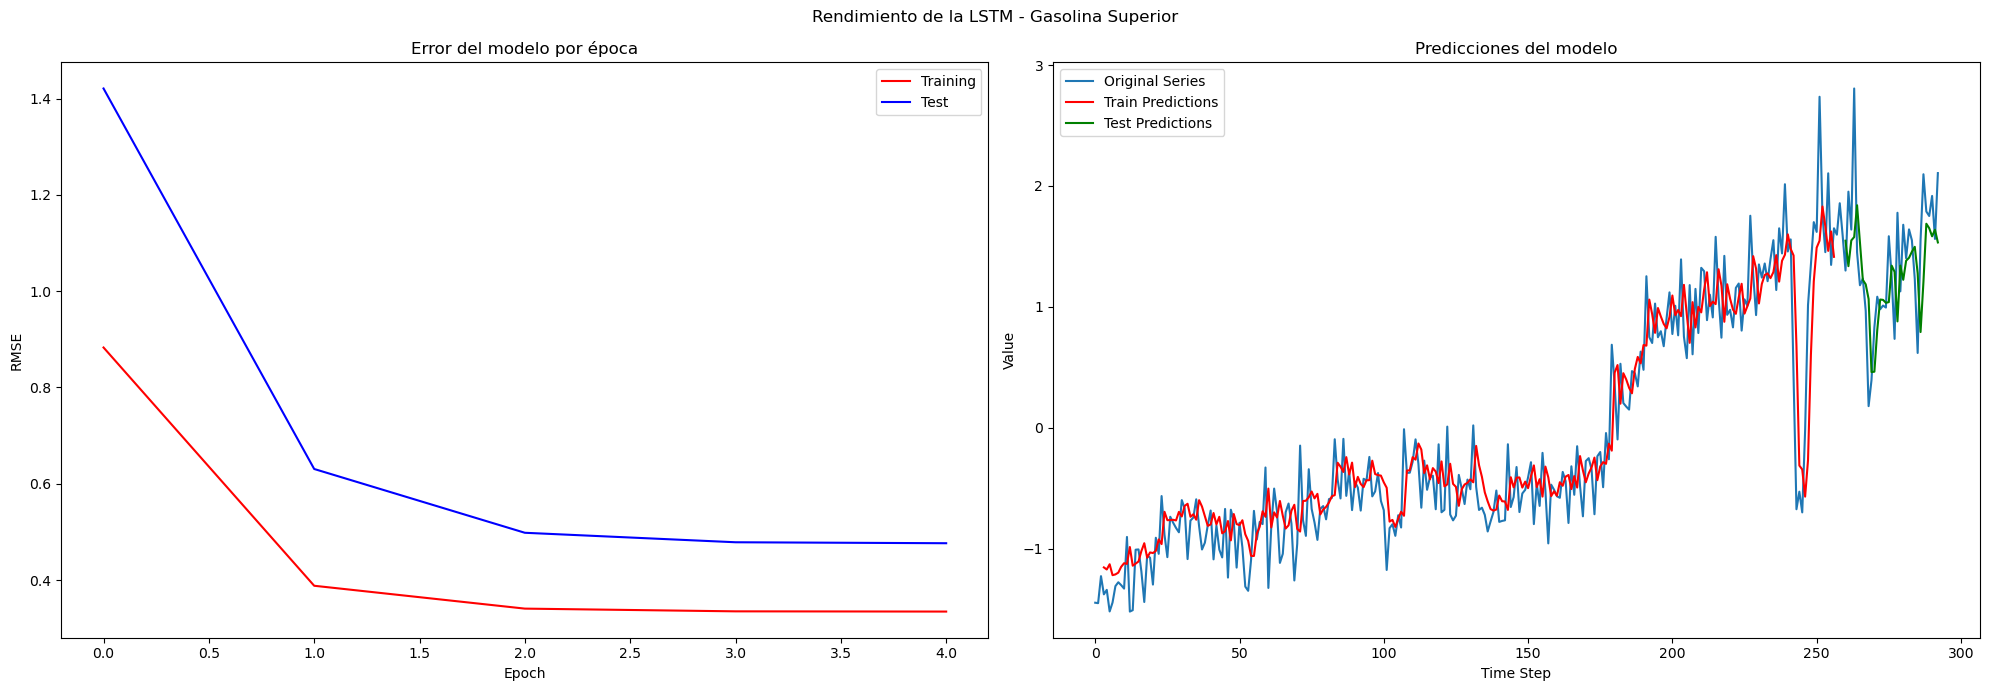

Resultados finales del modelo:
RMSE de Entrenamiento: 0.3346
RMSE de Pruebas: 0.4765


In [35]:
lstm_consumo_super = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=55,
    num_layers=1,
    lookback=3,
    n_epochs=100,
    test_size=36,
    device= device,
    dataframe=consumos,
    target_column='Gasolina Superior',
    plot_model=True,
    train_log=False,
    train_res=True
)

##### Gasolina Regular

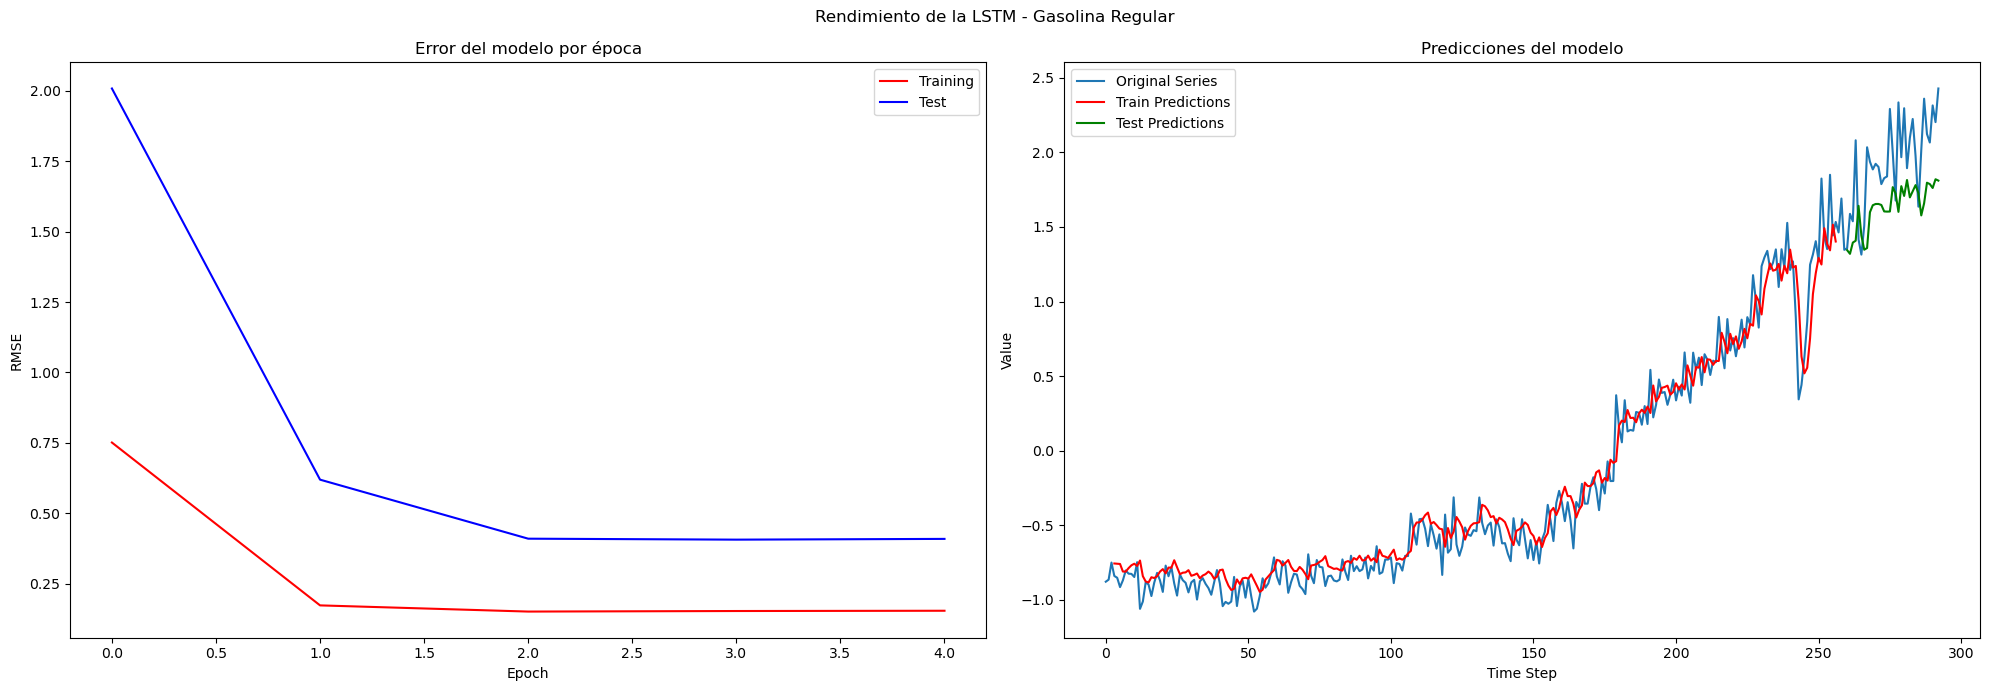

Resultados finales del modelo:
RMSE de Entrenamiento: 0.1539
RMSE de Pruebas: 0.4090


In [36]:
lstm_consumo_regular = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=2,
    lookback=3,
    n_epochs=100,
    test_size=36,
    device= device,
    dataframe=consumos,
    target_column='Gasolina Regular',
    plot_model=True,
    train_log=False,
    train_res=True
)

##### Diesel

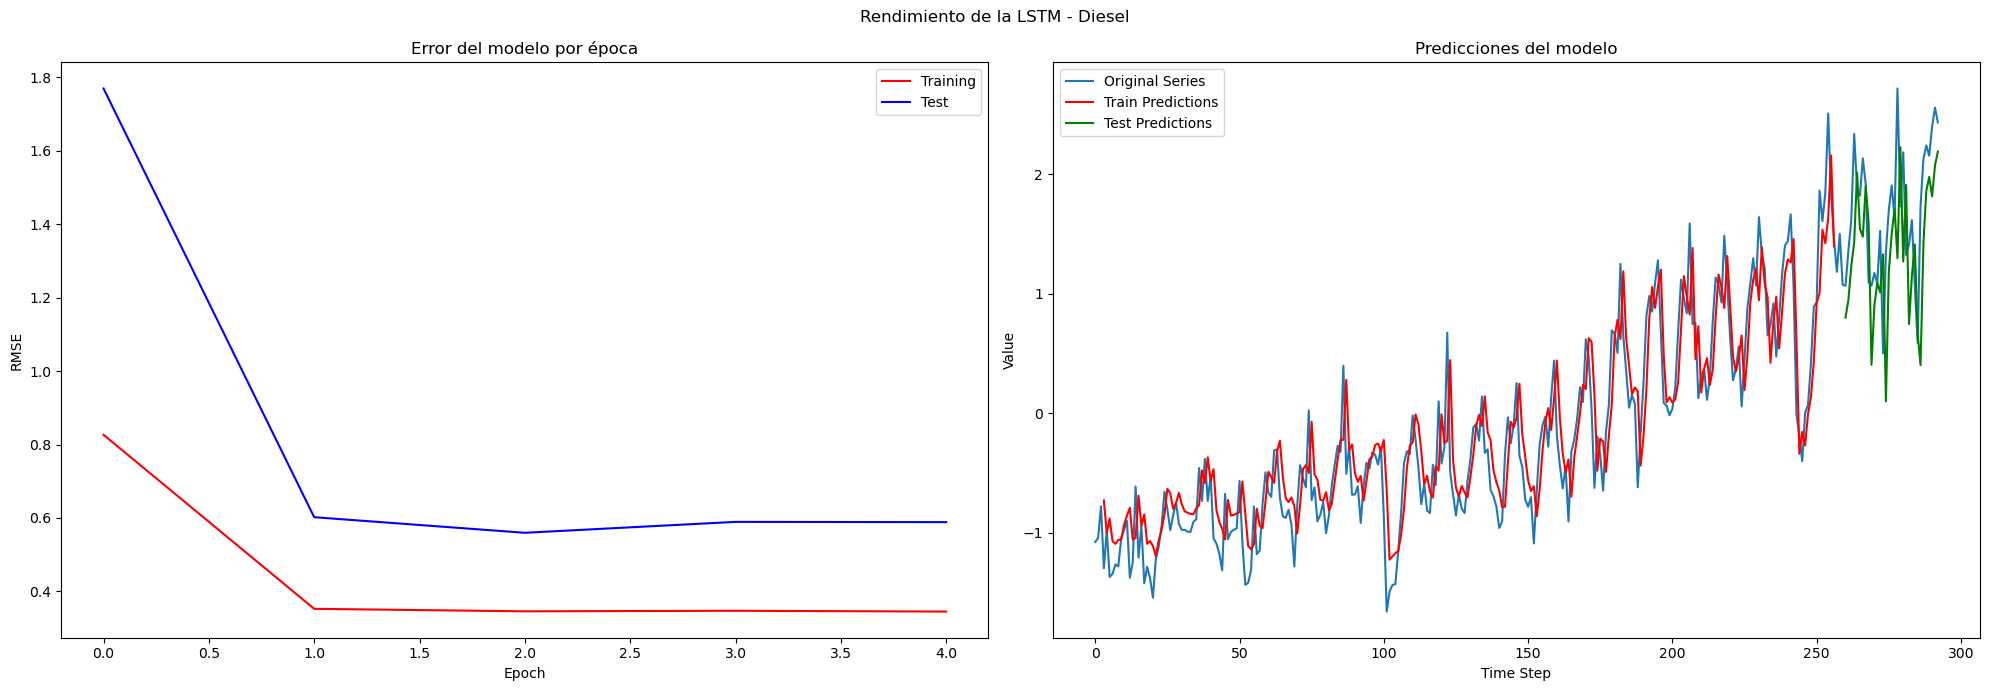

Resultados finales del modelo:
RMSE de Entrenamiento: 0.3452
RMSE de Pruebas: 0.5887


In [37]:
lstm_consumo_diesel = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=2,
    lookback=3,
    n_epochs=100,
    test_size=36,
    device= device,
    dataframe=consumos,
    target_column='Diesel',
    plot_model=True,
    train_log=False,
    train_res=True
)

##### Gas Propano

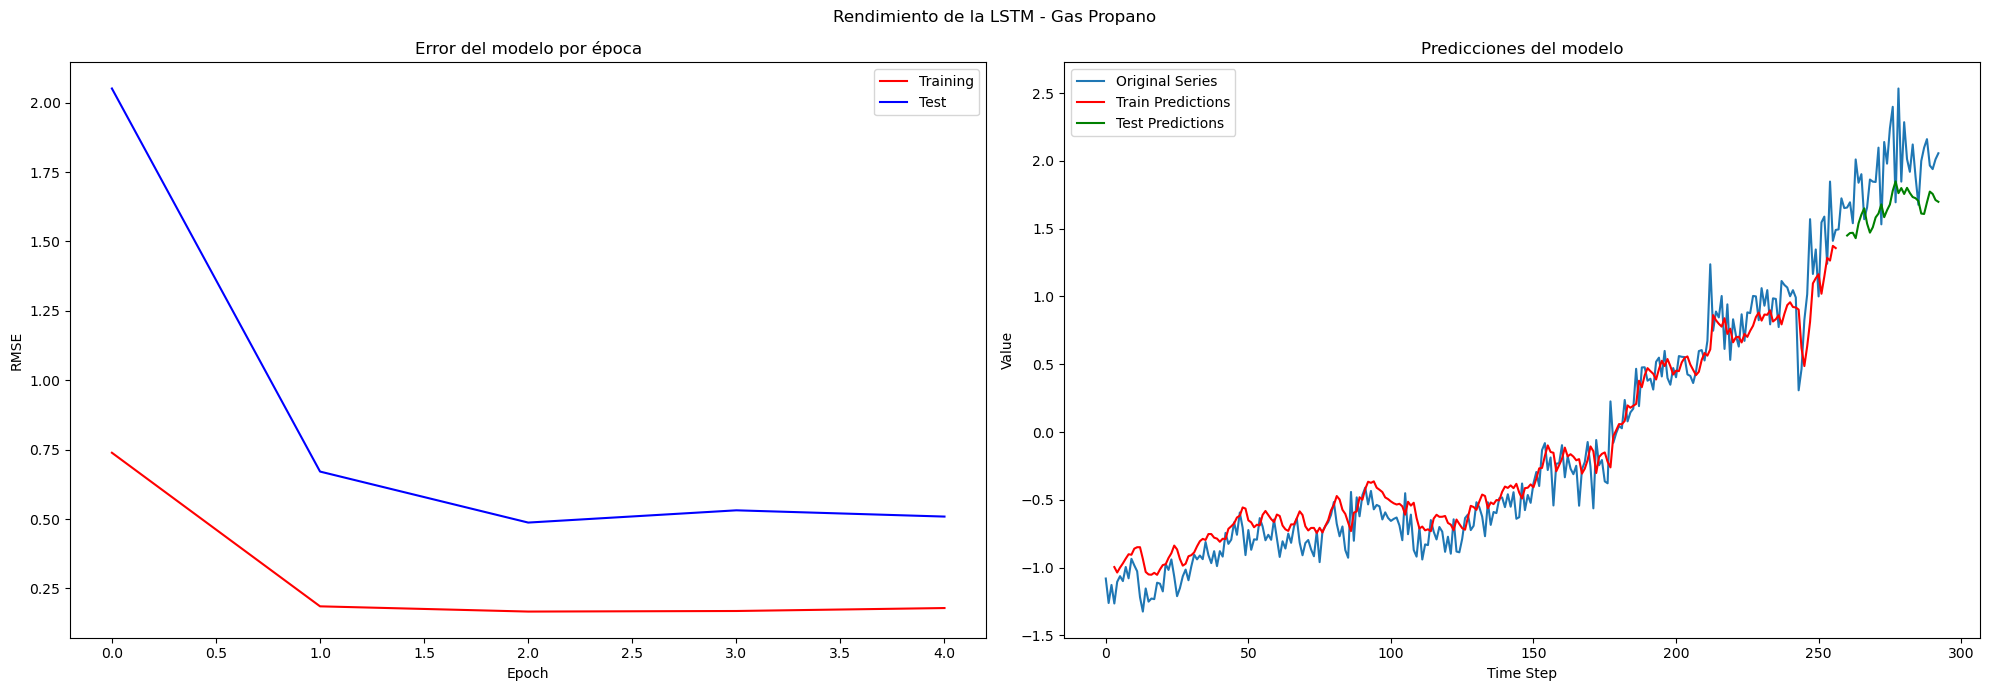

Resultados finales del modelo:
RMSE de Entrenamiento: 0.1793
RMSE de Pruebas: 0.5088


In [38]:
lstm_consumo_propano = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=2,
    lookback=3,
    n_epochs=100,
    test_size=36,
    device= device,
    dataframe=consumos,
    target_column='Gas Propano',
    plot_model=True,
    train_log=False,
    train_res=True
)

#### Importaciones de Combustible

##### Gasolina Superior

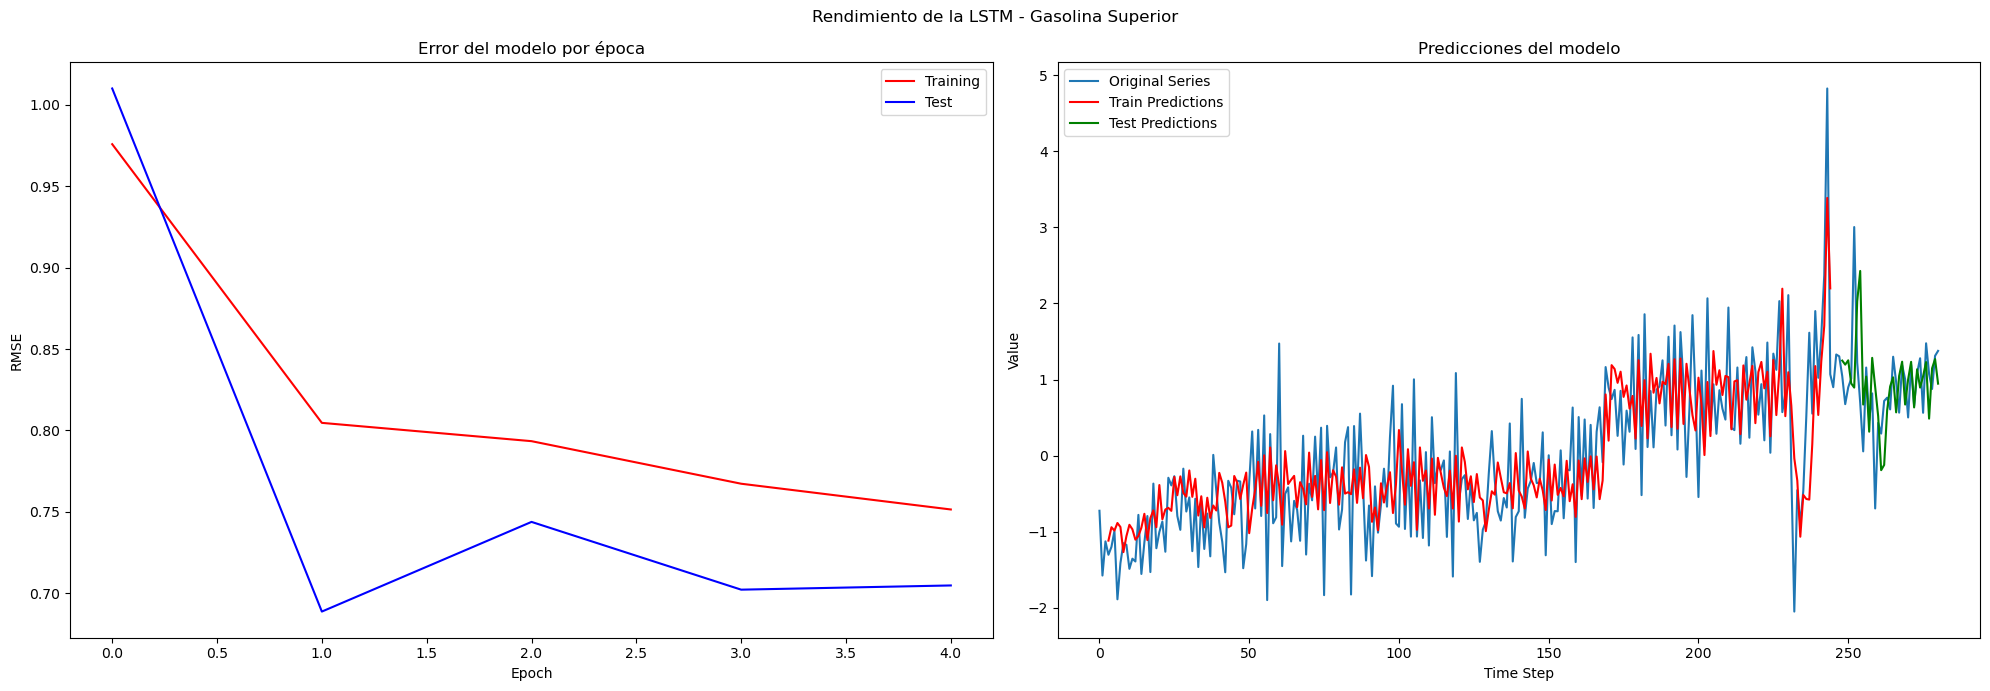

Resultados finales del modelo:
RMSE de Entrenamiento: 0.7515
RMSE de Pruebas: 0.7048


In [39]:
lstm_importacion_super = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=2,
    lookback=3,
    n_epochs=100,
    test_size=36,
    device= device,
    dataframe=importaciones,
    target_column='Gasolina Superior',
    plot_model=True,
    train_log=False,
    train_res=True
)

##### Gasolina Regular

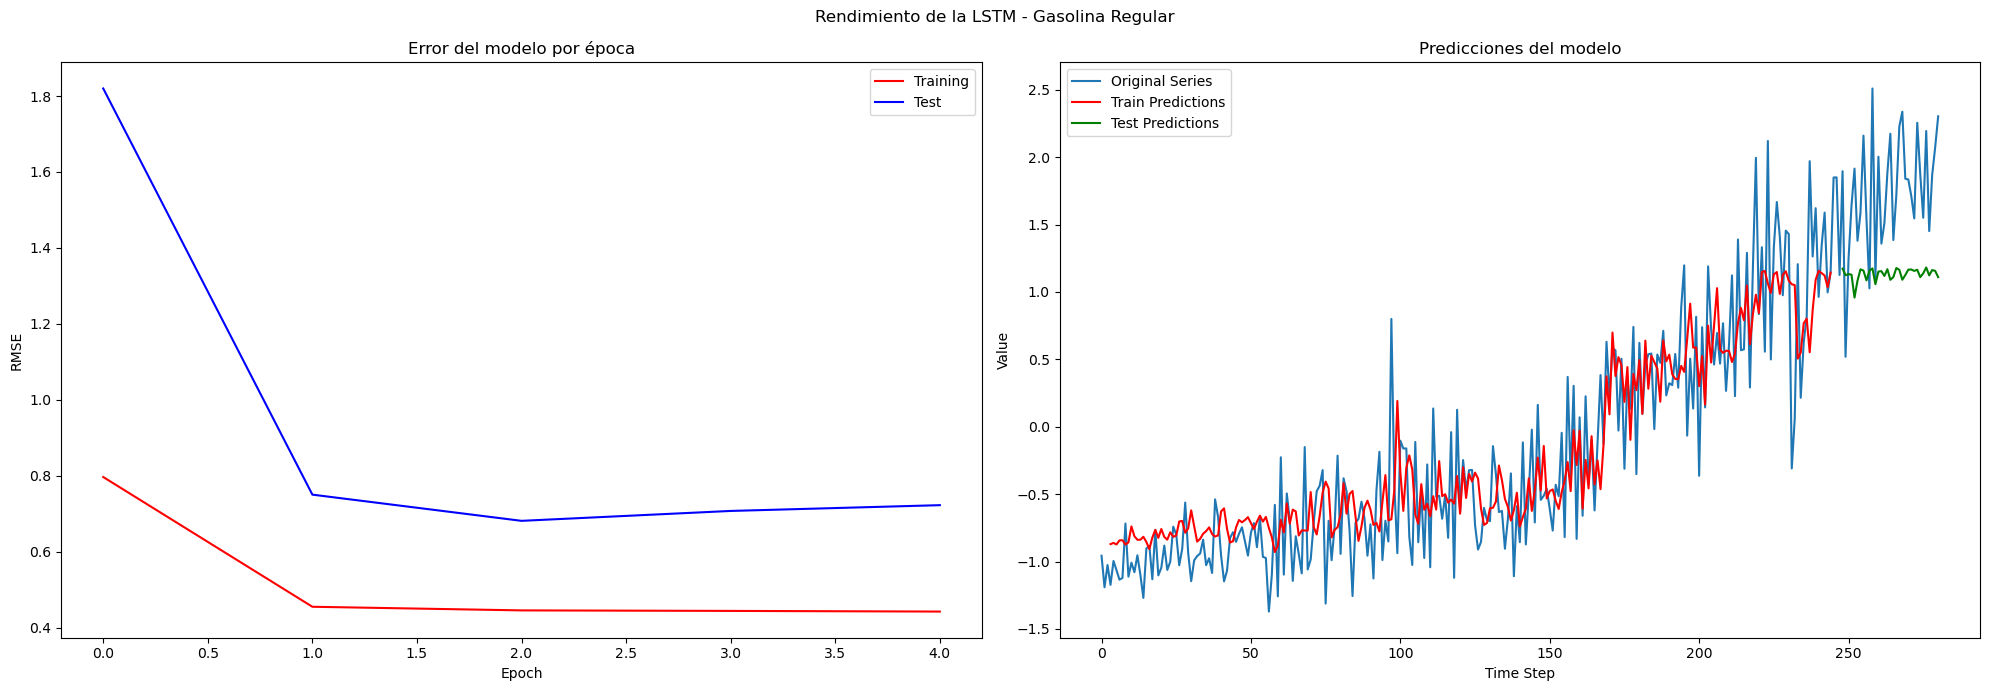

Resultados finales del modelo:
RMSE de Entrenamiento: 0.4420
RMSE de Pruebas: 0.7223


In [40]:
lstm_importacion_regular = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=2,
    lookback=3,
    n_epochs=100,
    test_size=36,
    device= device,
    dataframe=importaciones,
    target_column='Gasolina Regular',
    plot_model=True,
    train_log=False,
    train_res=True
)

##### Diesel

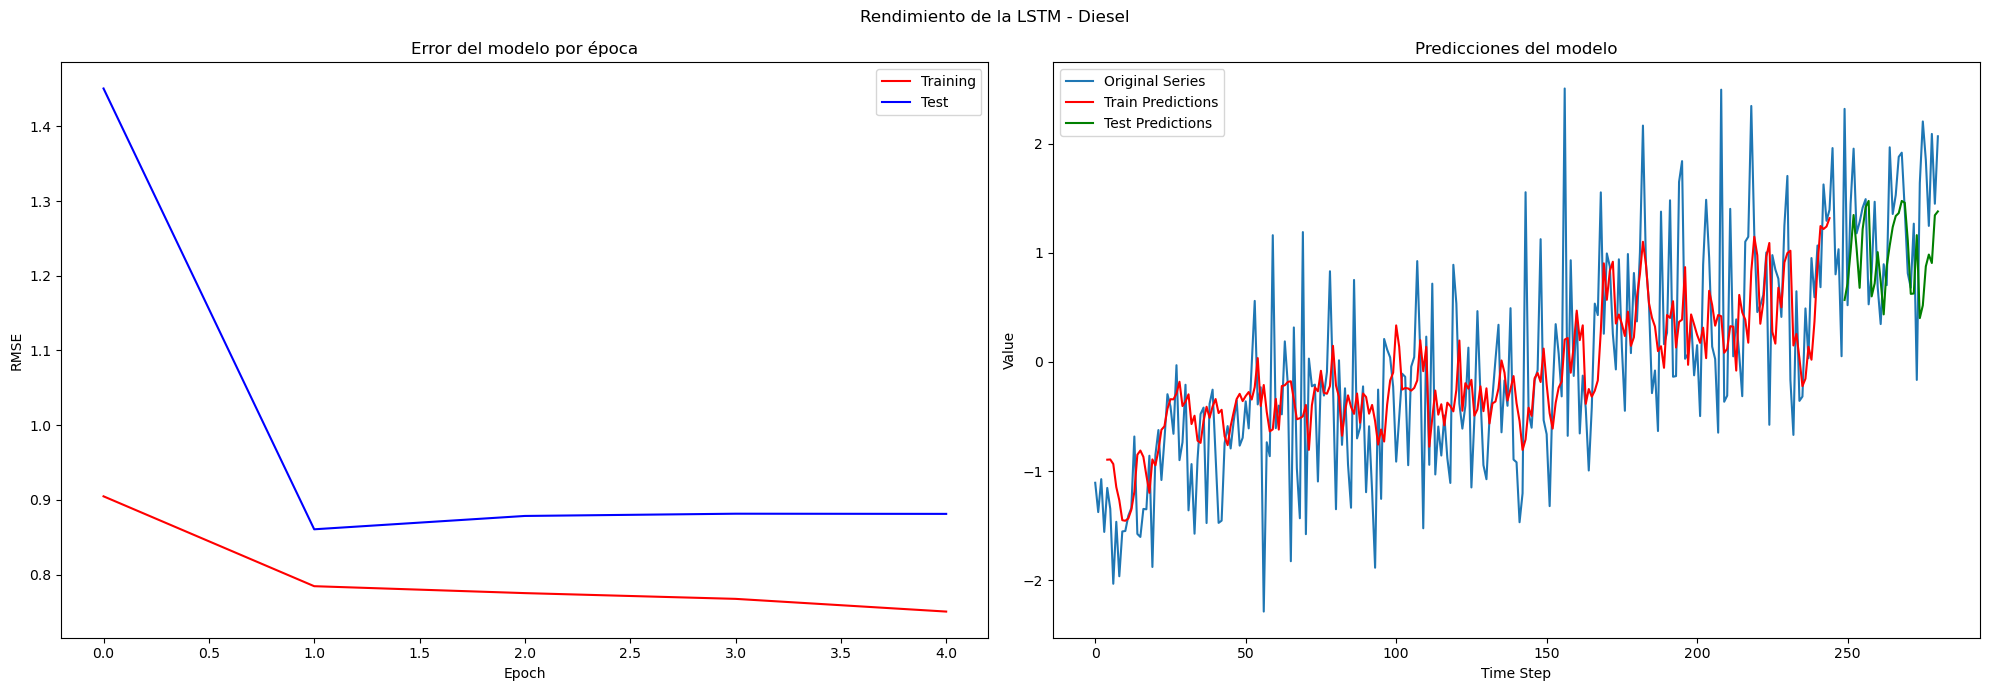

Resultados finales del modelo:
RMSE de Entrenamiento: 0.7504
RMSE de Pruebas: 0.8812


In [41]:
lstm_importacion_diesel = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=4,
    lookback=4,
    n_epochs=100,
    test_size=36,
    device= device,
    dataframe=importaciones,
    target_column='Diesel',
    plot_model=True,
    train_log=False,
    train_res=True
)

##### Gas Propano

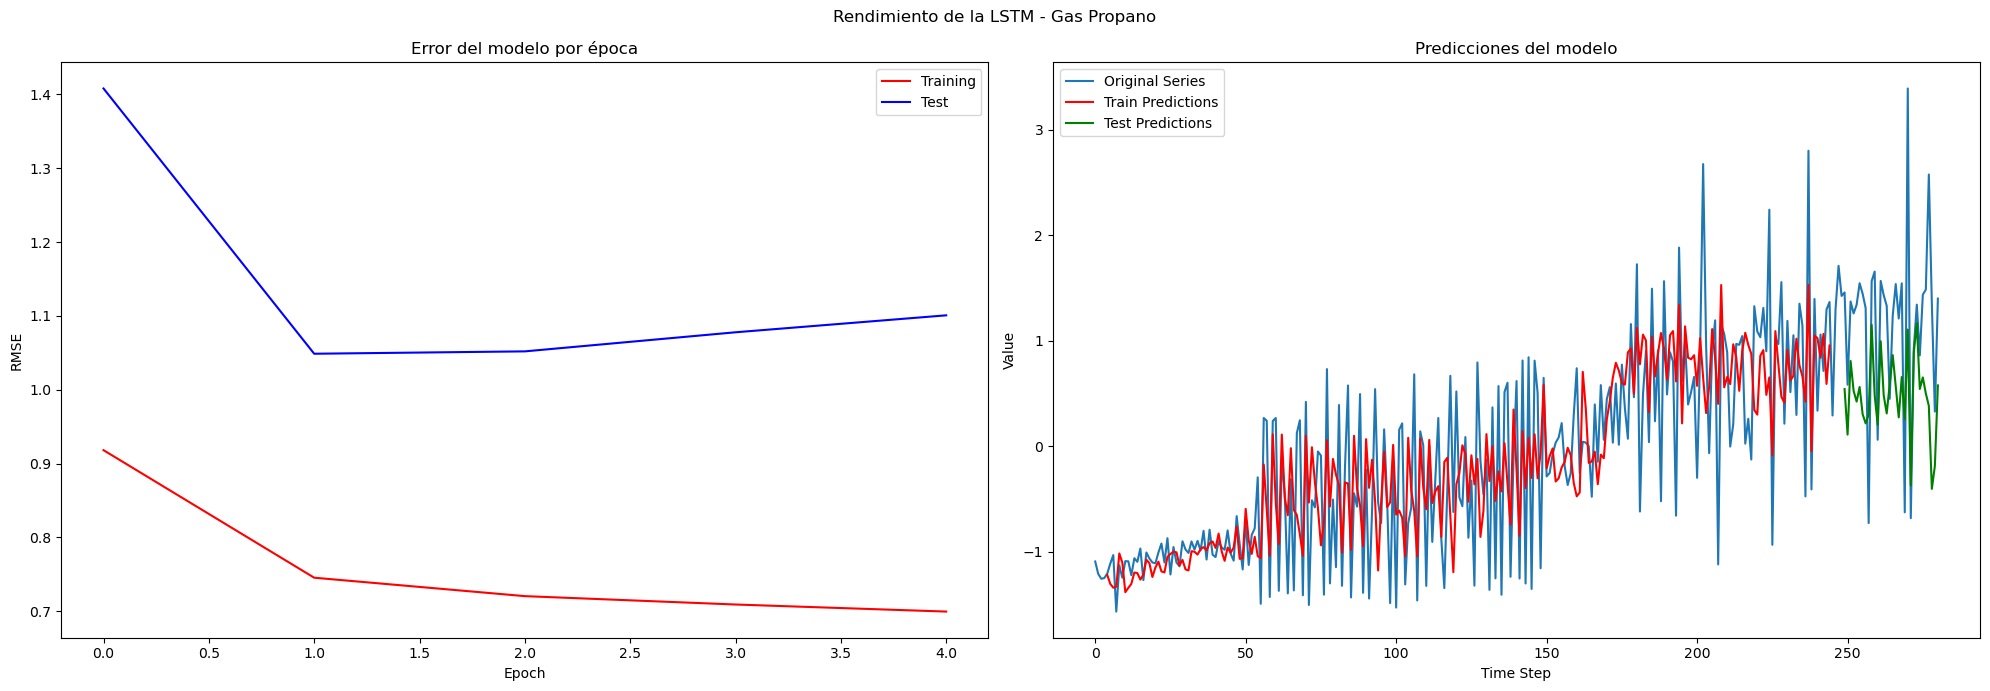

Resultados finales del modelo:
RMSE de Entrenamiento: 0.6997
RMSE de Pruebas: 1.1007


In [42]:
lstm_importacion_propano1 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=2,
    lookback=4,
    n_epochs=100,
    test_size=36,
    device= device,
    dataframe=importaciones,
    target_column='Gas Propano',
    plot_model=True,
    train_log=False,
    train_res=True
)

#### Precios de Combustibles

##### Gasolina Superior

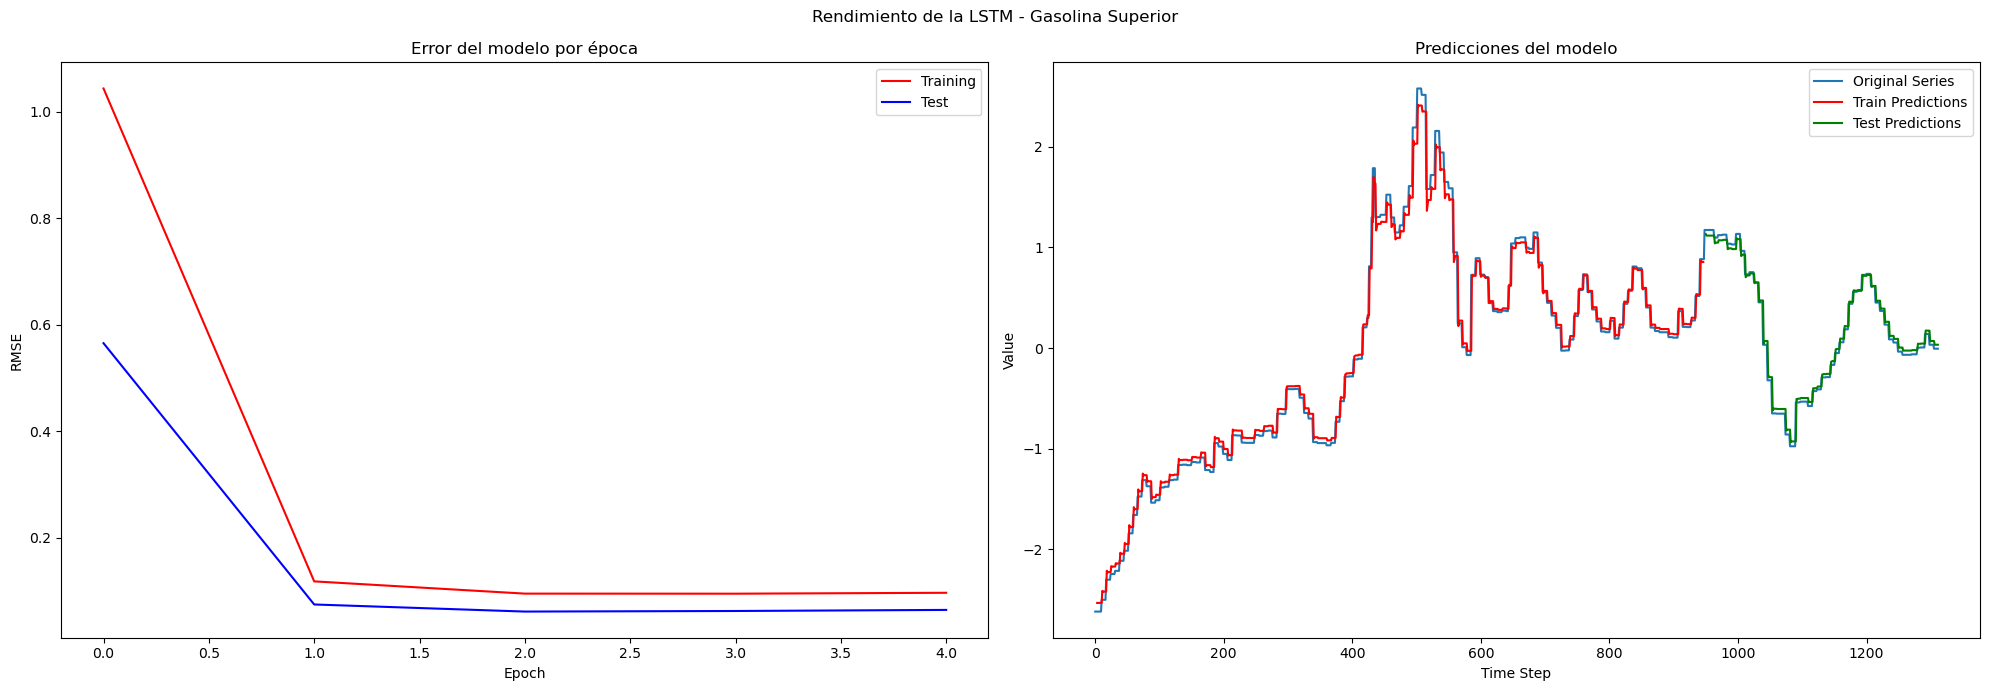

Resultados finales del modelo:
RMSE de Entrenamiento: 0.0963
RMSE de Pruebas: 0.0642


In [43]:
lstm_precios_super = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=2,
    lookback=3,
    n_epochs=100,
    test_size=365,
    device= device,
    dataframe=precios,
    target_column='Gasolina Superior',
    plot_model=True,
    train_log=False,
    train_res=True
)

##### Gasolina Regular

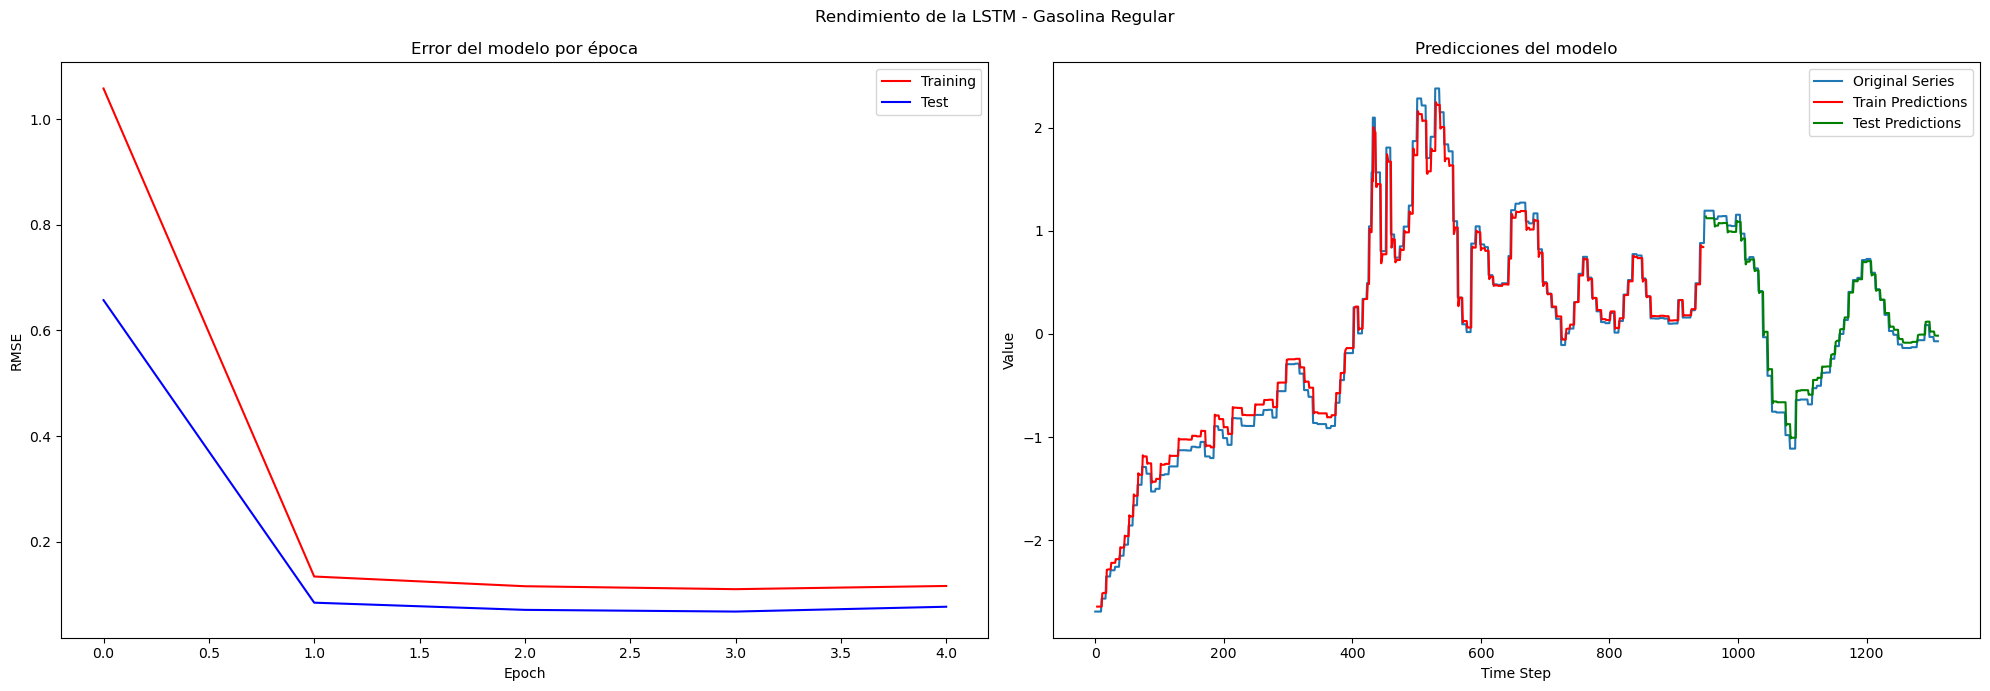

Resultados finales del modelo:
RMSE de Entrenamiento: 0.1161
RMSE de Pruebas: 0.0767


In [44]:
lstm_precios_regular1 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=2,
    lookback=3,
    n_epochs=100,
    test_size=365,
    device= device,
    dataframe=precios,
    target_column='Gasolina Regular',
    plot_model=True,
    train_log=False,
    train_res=True
)

##### Diesel

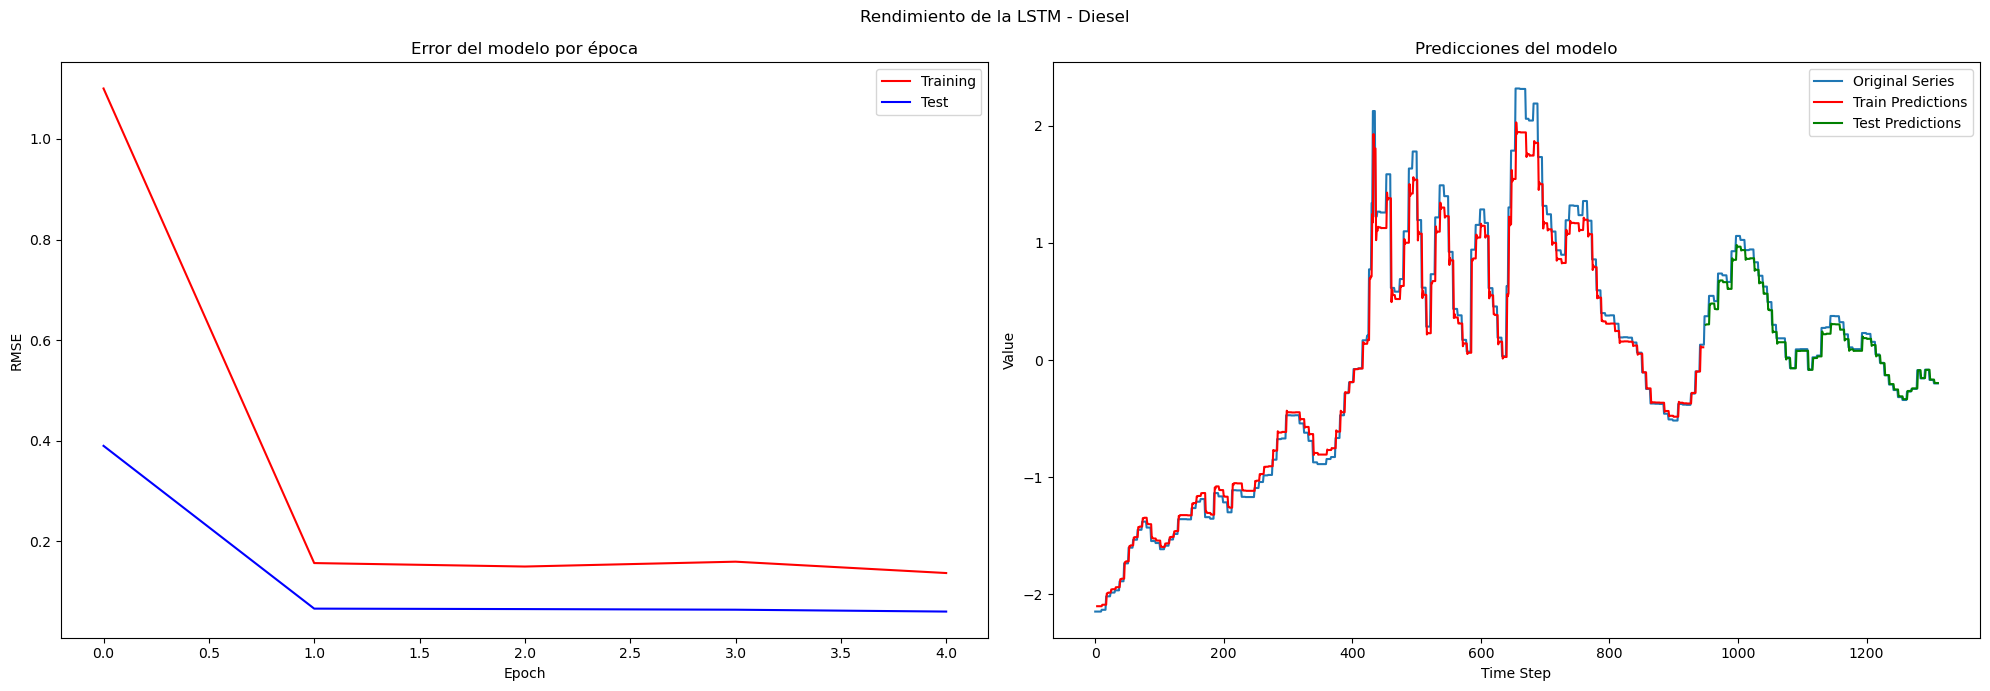

Resultados finales del modelo:
RMSE de Entrenamiento: 0.1372
RMSE de Pruebas: 0.0606


In [45]:
lstm_precios_diesel1 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=2,
    lookback=3,
    n_epochs=100,
    test_size=365,
    device= device,
    dataframe=precios,
    target_column='Diesel',
    plot_model=True,
    train_log=False,
    train_res=True
)

##### Gas Propano

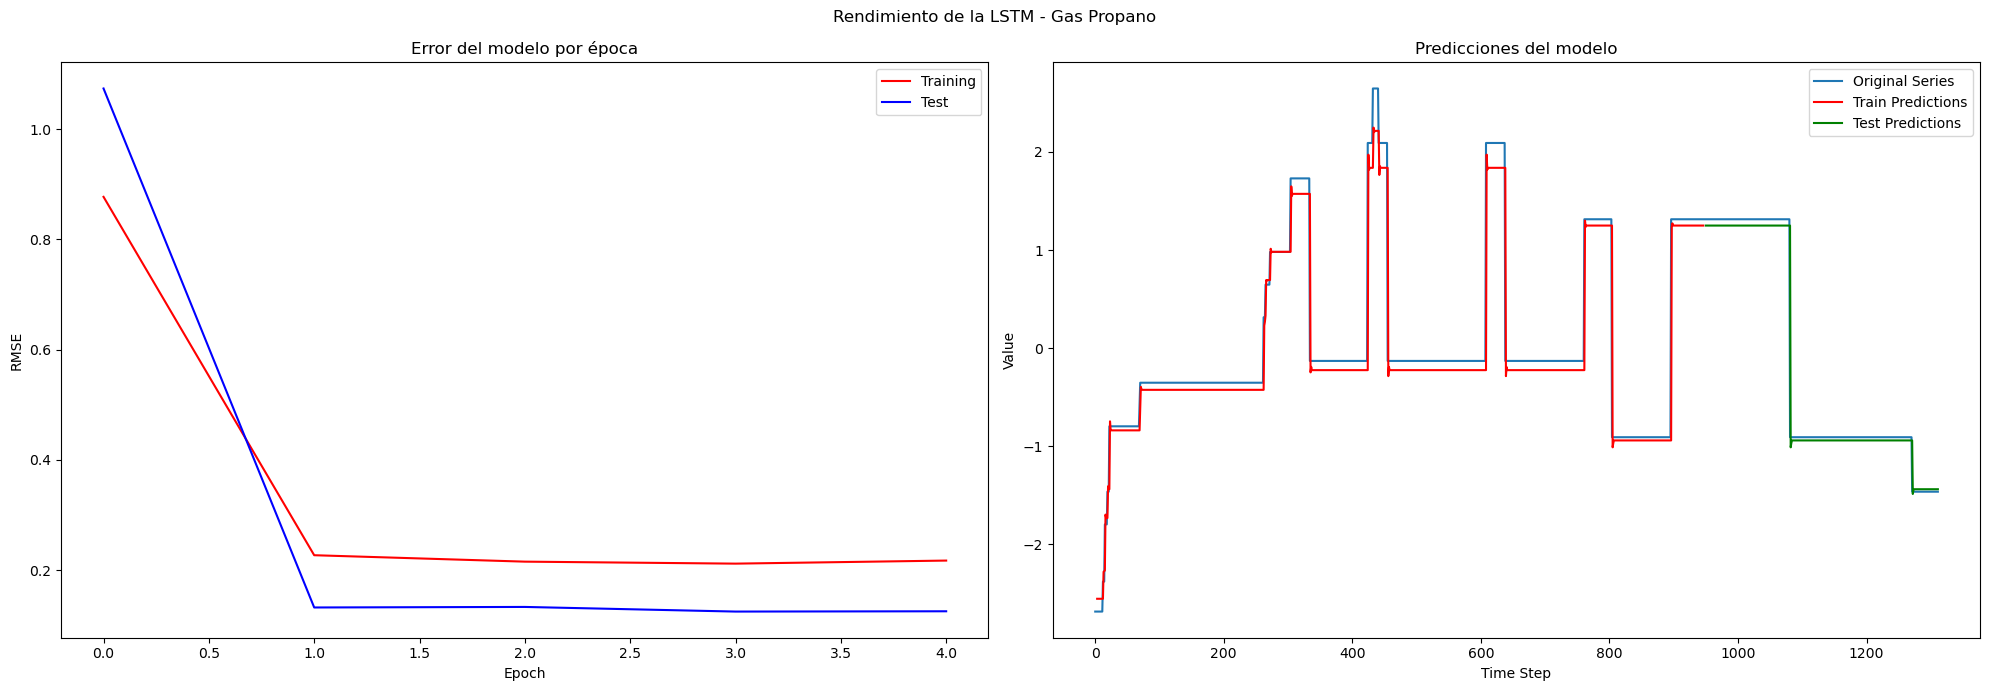

Resultados finales del modelo:
RMSE de Entrenamiento: 0.2175
RMSE de Pruebas: 0.1255


In [46]:
lstm_precios_propano1 = LSTM_Model(
    input_size=1,
    output_size=1,
    hidden_layers=50,
    num_layers=2,
    lookback=3,
    n_epochs=100,
    test_size=365,
    device= device,
    dataframe=precios,
    target_column='Gas Propano',
    plot_model=True,
    train_log=False,
    train_res=True
)